<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/Copy_of_TCAV_ImagePYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Show cases Testing with Concept Activation Vectors (TCAV) on Imagenet Dataset and GoogleNet model

In [1]:
! pip install captum
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str
from google.colab import files
import torch
import torch.nn as nn
import torchvision.models as models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00


In [2]:
import torch

# Check if CUDA (GPU) is available
print("CUDA available:", torch.cuda.is_available())

# Check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


CUDA available: False
Using device: cpu


## Load Data

In [3]:
#! pip install tcav
! pip install -q kaggle

In [4]:
# connect to the kaggle API to load the datasets
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                  title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
willianoliveiragibin/olympics-2024                                   Olympics 2024                                  352KB  2024-08-15 22:29:31           1870         33  1.0              
haseebindata/student-performance-predictions                         Student Performance Predictions                  9KB  2024-08-17 06:57:57           4193         95  0.9411765        
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                       1KB  2024-08-14 11:02:45           4170         74  1.0              
uom190346a/ai-powered-job-

In [5]:
# download and unzip the wildfire occurence dataset
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset
! mkdir -p wildfire-prediction-dataset
! unzip wildfire-prediction-dataset.zip -d wildfire-prediction-dataset

Streaming output truncated to the last 5000 lines.
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: wildfire-prediction-dataset/valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: wil

In [6]:
# download and unzip the landuse-concept dataset
! kaggle datasets download apollo2506/landuse-scene-classification
! mkdir -p concept-dataset
! unzip landuse-scene-classification.zip -d concept-dataset

Streaming output truncated to the last 5000 lines.
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000365.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000366.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000367.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000368.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000369.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000371.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000372.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000374.png  
  inflating: concept-dataset/images_train_test_val/train/mediumresidential/mediumresidential_000376.p

## Training model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms


In [8]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [9]:
import cv2
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

train_dir = '/content/wildfire-prediction-dataset/train'
val_dir = '/content/wildfire-prediction-dataset/valid'
test_dir = '/content/wildfire-prediction-dataset/test'

def cv2_loader(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

train_dataset = ImageFolder(root=train_dir, transform=data_transforms, loader=cv2_loader)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder(root=val_dir, transform=data_transforms, loader=cv2_loader)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = ImageFolder(root=test_dir, transform=data_transforms, loader=cv2_loader)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
model = models.resnet50(pretrained=True)


In [ ]:
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification (2 classes)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Optional: Validate the model at the end of each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy after Epoch {epoch+1}: {correct/total * 100:.2f}%")


Epoch 1/10, Loss: 0.1477
Validation Accuracy after Epoch 1: 92.79%
Epoch 2/10, Loss: 0.0922
Validation Accuracy after Epoch 2: 95.68%
Epoch 3/10, Loss: 0.0817
Validation Accuracy after Epoch 3: 97.21%
Epoch 4/10, Loss: 0.0712
Validation Accuracy after Epoch 4: 97.56%
Epoch 5/10, Loss: 0.0658
Validation Accuracy after Epoch 5: 98.27%
Epoch 6/10, Loss: 0.0561
Validation Accuracy after Epoch 6: 97.84%
Epoch 7/10, Loss: 0.0498
Validation Accuracy after Epoch 7: 95.92%
Epoch 8/10, Loss: 0.0497
Validation Accuracy after Epoch 8: 98.16%
Epoch 9/10, Loss: 0.0417
Validation Accuracy after Epoch 9: 98.35%
Epoch 10/10, Loss: 0.0440
Validation Accuracy after Epoch 10: 98.79%


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total * 100:.2f}%")


Test Accuracy: 99.13%


In [ ]:
torch.save(model.state_dict(), 'resnet50_finetuned_pytorch.pth')

In [ ]:
files.download('/content/resnet50_finetuned_pytorch.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # Ensure this matches the original model
# Load the model state dictionary and map it to the CPU if no GPU is available
model.load_state_dict(torch.load('/content/resnet50_finetuned_pytorch.pth', map_location=torch.device('cpu')))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-cd07e257c849>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

In [10]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # Ensure this matches the original model
model.load_state_dict(torch.load('/content/resnet50_finetuned_pytorch.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-68ad4058a60f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

## Defining image related transformations and functions

Let's define image transformation function.

In [11]:
import os
from PIL import Image

# Path to your dataset
root_dir = '/content/concept-dataset/images_train_test_val/train'

# Dictionary to hold the counts of images and their sizes
folder_image_count = {}
image_sizes = {}

# Iterate through each folder (concept)
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):
        folder_image_count[folder_name] = 0
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img_size = img.size  # (width, height)
                    folder_image_count[folder_name] += 1
                    if img_size not in image_sizes:
                        image_sizes[img_size] = 0
                    image_sizes[img_size] += 1
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

# Print the number of images per folder
print("Image count per folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

# Print the different image sizes found
print("\nDifferent image sizes found:")
for size, count in image_sizes.items():
    print(f"Size {size}: {count} images")


Image count per folder:
intersection: 350 images
baseballdiamond: 350 images
storagetanks: 350 images
overpass: 350 images
beach: 350 images
agricultural: 350 images
tenniscourt: 350 images
airplane: 350 images
sparseresidential: 350 images
buildings: 350 images
river: 350 images
forest: 350 images
runway: 350 images
denseresidential: 350 images
chaparral: 350 images
mobilehomepark: 350 images
golfcourse: 350 images
freeway: 350 images
mediumresidential: 350 images
parkinglot: 350 images
harbor: 350 images

Different image sizes found:
Size (256, 256): 7200 images
Size (249, 256): 4 images
Size (250, 256): 7 images
Size (256, 255): 5 images
Size (252, 256): 5 images
Size (256, 253): 11 images
Size (256, 249): 7 images
Size (254, 256): 11 images
Size (255, 256): 11 images
Size (247, 247): 30 images
Size (256, 254): 6 images
Size (247, 256): 4 images
Size (253, 256): 21 images
Size (242, 256): 2 images
Size (256, 251): 19 images
Size (256, 247): 3 images
Size (257, 257): 4 images


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to resize and convert images to tensors (without normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Converts to tensor
])

# Load the dataset with the resizing transform
dataset = datasets.ImageFolder(root='/content/concept-dataset/images_train_test_val/train', transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)


In [13]:
import torch

# Initialize sums and squared sums
mean = torch.zeros(3)
std = torch.zeros(3)

for images, _ in loader:
    images = images.view(images.size(0), images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print(f'Mean: {mean}')
print(f'Std: {std}')


Mean: tensor([0.4584, 0.4677, 0.4368])
Std: tensor([0.2367, 0.2308, 0.2192])


In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Converts to tensor
    transforms.Normalize(
        mean=mean,  # Replace with your calculated mean
        std=std     # Replace with your calculated std
    ),
])


Now let's define a few helper functions.

In [15]:
import cv2
from PIL import Image

def get_tensor_from_filename(filename):
    # Load the image using cv2
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB

    # Convert to PIL Image to use torchvision.transforms
    img = Image.fromarray(img)

    # Apply the transform function to get the tensor
    return transform(img)
import os
import glob
import cv2
from PIL import Image

def load_image_tensors(class_name, root_path='/content/concept-dataset/images_train_test_val/train', apply_transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        # Load the image using cv2
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Convert to PIL Image for compatibility with torchvision.transforms
        img = Image.fromarray(img)

        # Apply the transform and append the tensor
        tensors.append(transform(img) if apply_transform else img)

    return tensors


Defining a helper function to load predefined concepts. `assemble_concept` function reads the concepts using a directory path where the concepts are residing and constructs concept object.

In [16]:
import os

'''def assemble_concept(name, id, concepts_path='/content/concept-dataset/images_train_test_val/train'):
    concept_path = os.path.join(concepts_path, name)

    # Load tensors for all images in the concept folder
    tensors = load_image_tensors(name, root_path=concepts_path)

    # Create a Concept object directly with the loaded tensors
    return Concept(id=id, name=name, data_iter=tensors)
'''

# Define the function to load and transform images
def assemble_concept(name, id, concepts_path="/content/concept-dataset/images_train_test_val/train"):
    concept_path = os.path.join(concepts_path, name) + "/"

    # Use the CustomIterableDataset and dataset_to_dataloader as in the tutorial
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    # Create and return the Concept object with a data iterator
    return Concept(id=id, name=name, data_iter=concept_iter)


In [21]:
import random
import shutil
# Paths to source directories
wildfire_src = '/content/wildfire-prediction-dataset/train/wildfire'
nowildfire_src = '/content/wildfire-prediction-dataset/train/nowildfire'

! mkdir /content/sampled_classes
sampled_classes = '/content/sampled_classes'
# Paths to target TCAV directories
wildfire_dest = os.path.join(sampled_classes, 'wildfire')
nowildfire_dest = os.path.join(sampled_classes, 'nowildfire')

# Create directories if they don't exist
os.makedirs(wildfire_dest, exist_ok=True)
os.makedirs(nowildfire_dest, exist_ok=True)

# Copy 500 images randomly from wildfire and nowildfire to the target directories
num_images_to_copy = 500

# Copy wildfire images
wildfire_images = random.sample(os.listdir(wildfire_src), num_images_to_copy)
for img in wildfire_images:
    shutil.copy(os.path.join(wildfire_src, img), wildfire_dest)

# Copy nowildfire images
nowildfire_images = random.sample(os.listdir(nowildfire_src), num_images_to_copy)
for img in nowildfire_images:
    shutil.copy(os.path.join(nowildfire_src, img), nowildfire_dest)

# Diagnostic prints
print(f"Copied {len(os.listdir(wildfire_dest))} images to the wildfire folder.")
print(f"Copied {len(os.listdir(nowildfire_dest))} images to the nowildfire folder.")


mkdir: cannot create directory ‘/content/sampled_classes’: File exists
Copied 500 images to the wildfire folder.
Copied 500 images to the nowildfire folder.


In [22]:
# Define the paths
wildfire_base_path = '/content/sampled_classes/'
landuse_base_path = '/content/concept-dataset/images_train_test_val/train/'

# List of all concept names and the subset of concepts you're interested in
concept_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
                 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                 'storagetanks', 'tenniscourt']

subset_concepts = ['agricultural', 'beach', 'forest', 'freeway', 'river',
                   'sparseresidential', 'denseresidential', 'harbor']

In [23]:
import random
num_random_exp = 10
random_folders = [f'random_{i}' for i in range(num_random_exp)]
# Step 2: Organize random folders for experiments (adjusted to store paths only)
remaining_concepts = list(set(concept_names) - set(subset_concepts))

# Prepare a pool of image paths from remaining concepts without reuse
random_pool = []

print("\nCreating a pool of image paths from remaining concepts...")
for concept in remaining_concepts:
    concept_src_path = os.path.join(landuse_base_path, concept)
    concept_images = os.listdir(concept_src_path)
    random_pool.extend([(concept_src_path, img) for img in concept_images])

# Shuffle the random pool to ensure randomness
random.shuffle(random_pool)

# Diagnostic print to check the size of the random pool
print(f"Total images available in random pool: {len(random_pool)}")

# Now that we have the pool of paths, we will only store the file paths for distribution
# No images are being loaded into memory at this stage, just their paths are stored.



Creating a pool of image paths from remaining concepts...
Total images available in random pool: 4550


In [24]:
! mkdir /content/random

In [25]:
import shutil
# Step 3: Distribute paths to random folders with the naming convention "random500_x"
print("\nDistributing images to random folders...")
images_per_folder = len(random_pool) // num_random_exp

for i in range(num_random_exp):
    # Generate folder names like "random500_0", "random500_1", etc., directly under /content/tcav_data/
    random_folder_name = f"random500_{i}"
    random_folder_path = os.path.join("/content/random", random_folder_name)  # No 'randoms/' subfolder
    os.makedirs(random_folder_path, exist_ok=True)

    # Get the paths for this folder
    folder_images = random_pool[i * images_per_folder:(i + 1) * images_per_folder]

    # Copy the images from their source paths to the random folder
    for src_path, img in folder_images:
        shutil.copy(os.path.join(src_path, img), random_folder_path)

    # Diagnostic print
    print(f"Assigned {len(os.listdir(random_folder_path))} images to folder: {random_folder_name}")



Distributing images to random folders...
Assigned 455 images to folder: random500_0
Assigned 455 images to folder: random500_1
Assigned 455 images to folder: random500_2
Assigned 455 images to folder: random500_3
Assigned 455 images to folder: random500_4
Assigned 455 images to folder: random500_5
Assigned 455 images to folder: random500_6
Assigned 455 images to folder: random500_7
Assigned 455 images to folder: random500_8
Assigned 455 images to folder: random500_9


In [26]:
from torchvision import datasets

dataset = datasets.ImageFolder(root='/content/wildfire-prediction-dataset/train')
class_to_idx = dataset.class_to_idx
print(class_to_idx)


{'nowildfire': 0, 'wildfire': 1}


In [27]:
# Define the base path to your concepts
concepts_path = "/content/concept-dataset/images_train_test_val/train"

# Assemble the specific concepts you're interested in
agricultural_concept = assemble_concept("agricultural", 0, concepts_path=concepts_path)
beach_concept = assemble_concept("beach", 1, concepts_path=concepts_path)
forest_concept = assemble_concept("forest", 2, concepts_path=concepts_path)

# Add more as needed...
# freeway_concept = assemble_concept("freeway", 3, concepts_path=concepts_path)
# river_concept = assemble_concept("river", 4, concepts_path=concepts_path)
# ...

# Assemble the random concepts
random_0_concept = assemble_concept("random500_0", 3, concepts_path="/content/random")
random_1_concept = assemble_concept("random500_1", 4, concepts_path="/content/random")
random_2_concept = assemble_concept("random500_2", 5, concepts_path="/content/random")
# Add more random concepts as needed...


Let\'s visualize some samples from those concepts

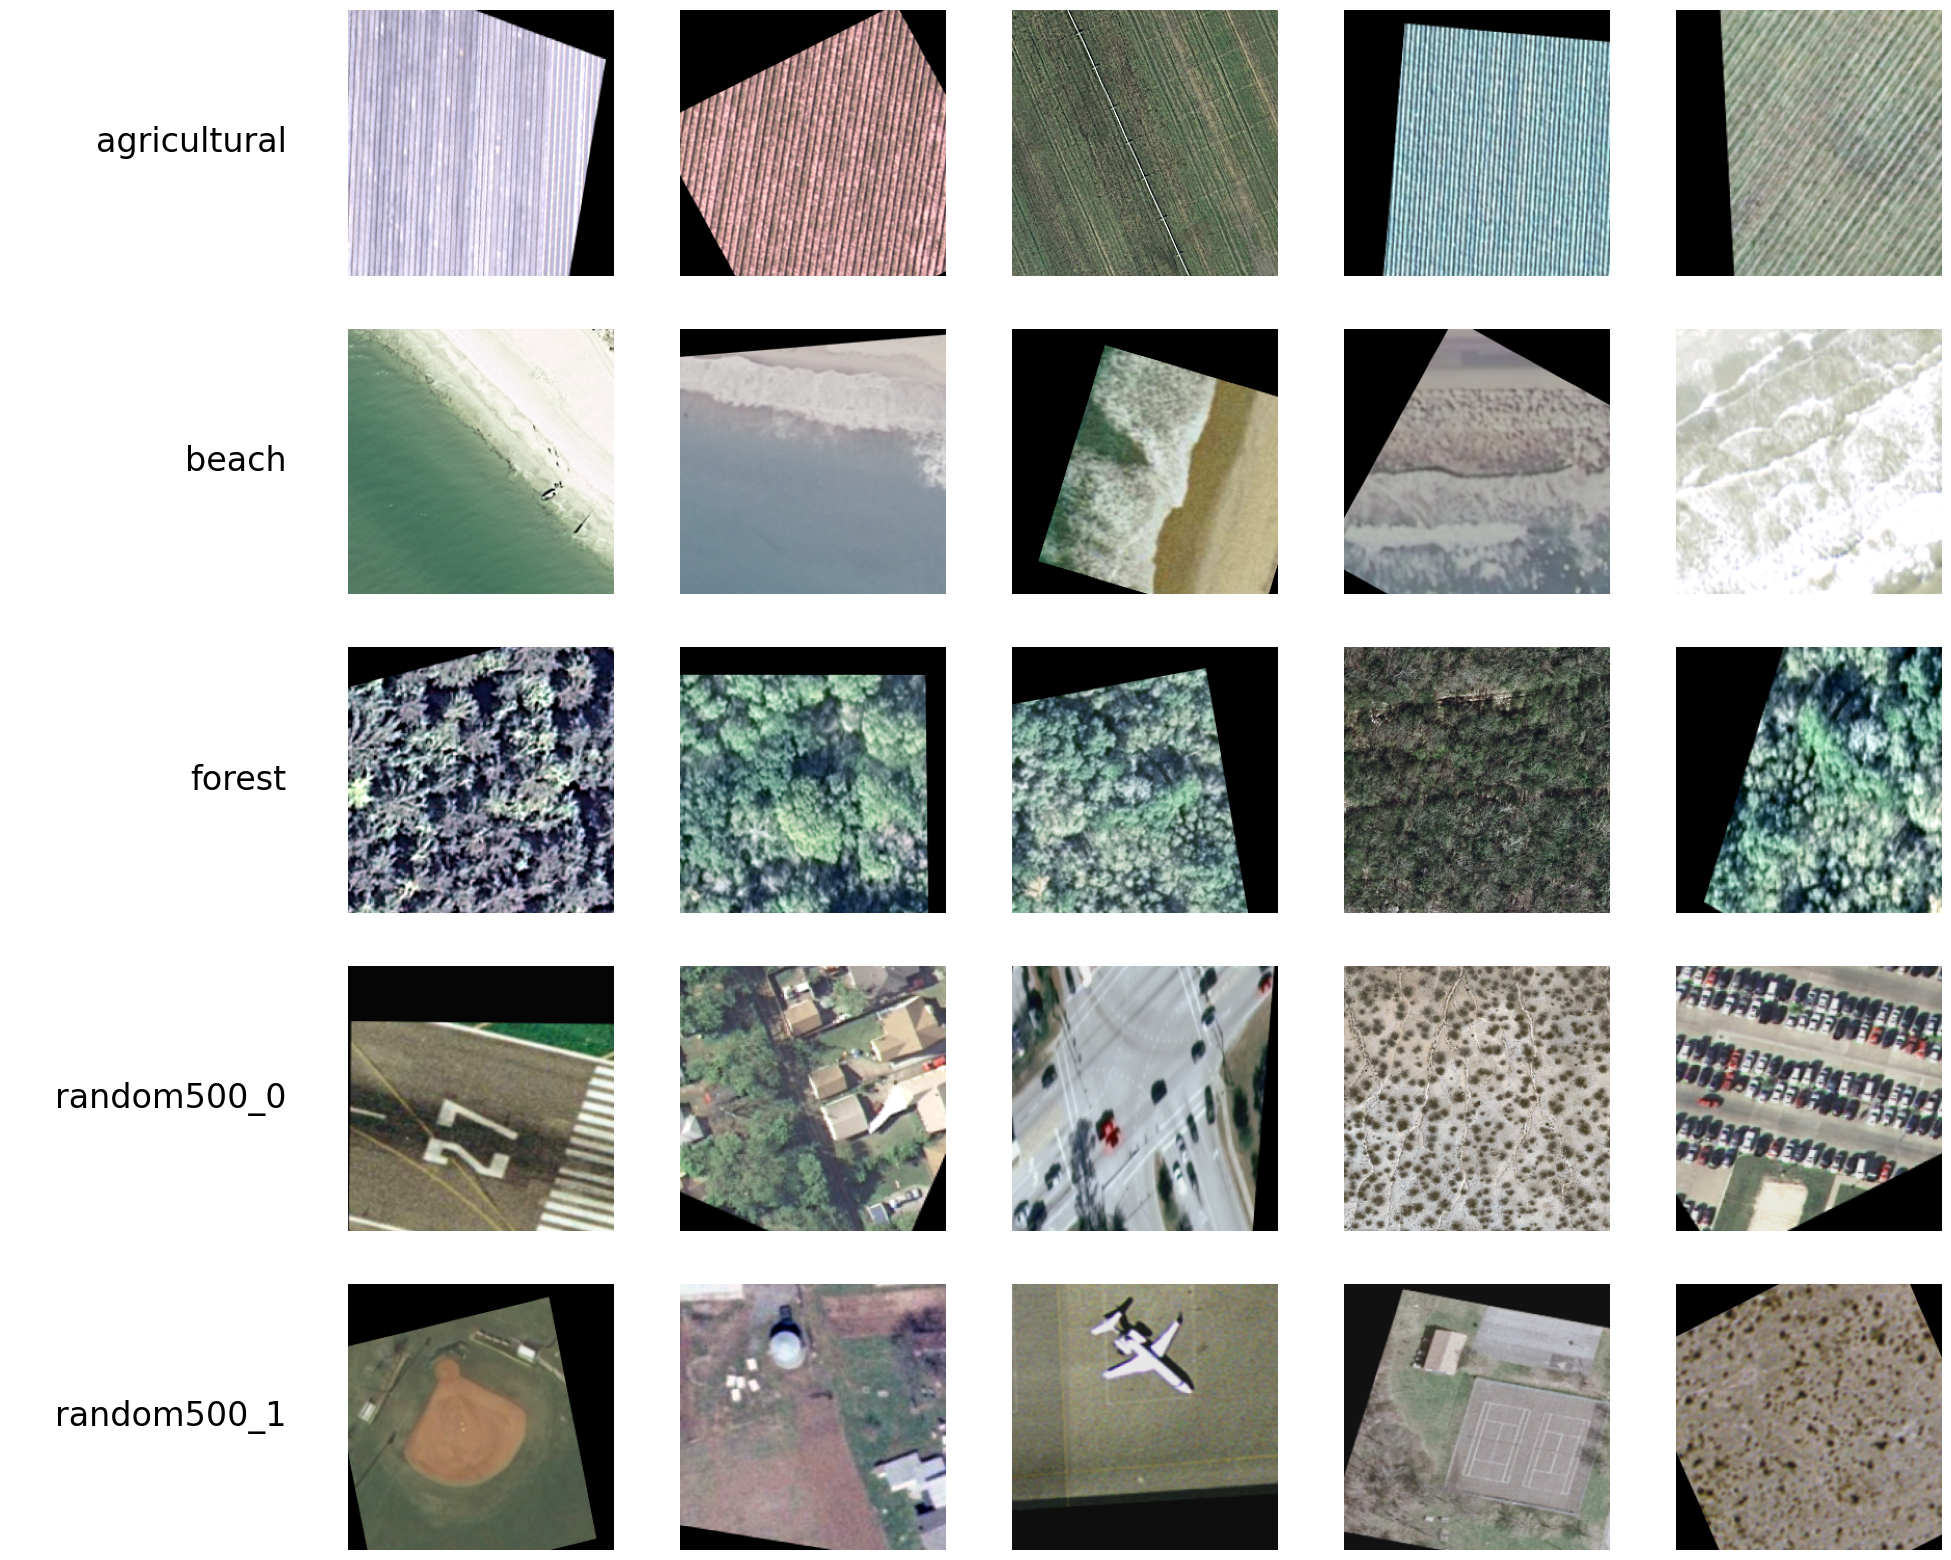

In [28]:
import os
import glob
import matplotlib.pyplot as plt

# Number of figures and concepts to visualize
n_figs = 5
n_concepts = 5  # Adjust this based on the number of concepts you want to visualize

# List your concepts here
concepts = [agricultural_concept, beach_concept, forest_concept, random_0_concept, random_1_concept]

# Prepare the figure and axes
fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize=(25, 4 * n_concepts))

# Iterate over each concept and its corresponding subplot row
for c, concept in enumerate(concepts):
    # Use the appropriate path based on whether the concept is random or not
    if 'random' in concept.name:
        concept_path = os.path.join("/content/random", concept.name) + "/"
    else:
        concept_path = os.path.join(concepts_path, concept.name) + "/"

    img_files = glob.glob(concept_path + '*')

    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

# Display the plots
plt.show()


For this tutorial, we will load GoogleNet model and set in eval mode.

# Computing TCAV Scores

Next, let's create TCAV class by passing the instance of GoogleNet model, a custom classifier and the list of layers where we would like to test the importance of concepts.

The custom classifier will be trained to learn classification boundaries between concepts. We offer a default implementation of Custom Classifier in captum library so that the users do not need to define it. Captum users, hoowever, are welcome to define their own classifers with any custom logic. CustomClassifier class extends abstract Classifier class and provides implementations for training workflow for the classifier and means to access trained weights and classes. Typically, this can be, but is not limited to a classier, from sklearn library. In this case CustomClassifier wraps `linear_model.SGDClassifier` algorithm from sklearn library.

In [ ]:
print(model)

In [29]:
from captum.concept import TCAV
from captum.attr import LayerIntegratedGradients

# Choose one layer, for example, 'layer4' in a ResNet model
layer = ['layer4']

# Set up TCAV with the chosen layer
mytcav = TCAV(model=model,
              layers=layer,
              layer_attr_method=LayerIntegratedGradients(model, None, multiply_by_inputs=False))


/usr/local/lib/python3.10/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


##### Defining experimantal sets for CAV

Then, lets create 2 experimental sets: ["striped", "random_0"] and ["striped", "random_1"].

We will train a classifier for each experimal set that learns hyperplanes which separate the concepts in each experimental set from one another. This is especially interesting when later we want to perform two-sided statistical significance testing in order to confirm or reject the significance of a concept in a specific layer for predictions.

Now, let's load sample images from imagenet. The goal is to test how sensitive model predictions are to predefined concepts such as 'striped' when predicting 'zebra' class.



In [30]:
# Define the experimental set with target concepts paired with random concepts
experimental_set_rand = [
    #[agricultural_concept, random_0_concept],
    #[agricultural_concept, random_1_concept],
    #[beach_concept, random_0_concept],
    #[beach_concept, random_1_concept],
    [forest_concept, random_0_concept],
    #[forest_concept, random_1_concept]
    # Add more pairs if desired, e.g., freeway_concept, river_concept, etc.
]


Now, let's load sample images from imagenet. The goal is to test how sensitive model predictions are to predefined concepts such as 'striped' when predicting 'zebra' class.

Please, download zebra images and place them under `data/tcav/image/imagenet/zebra` folder in advance before running the cell below. For our experiments we used 50 different zebra images from imagenet dataset.


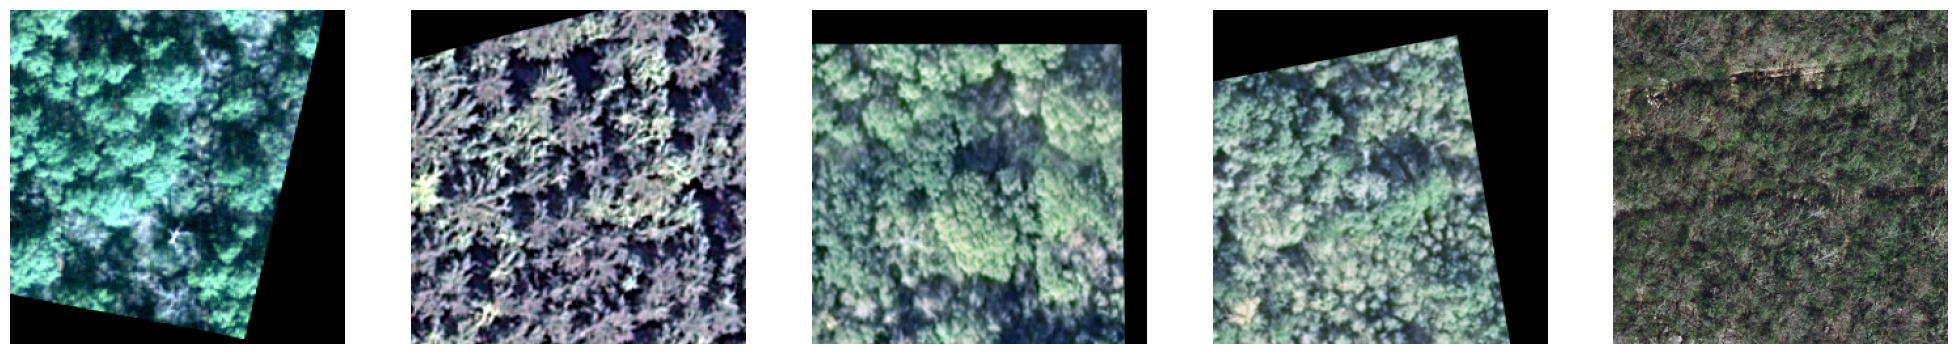

In [31]:
import os
import glob
import matplotlib.pyplot as plt

# Define the concept path and concept name
#concept_name = 'agricultural'
concept_name = 'forest'
concept_folder = os.path.join(concepts_path, concept_name)

# Load image filenames (adjusted to load any image type)
image_files = glob.glob(os.path.join(concept_folder, '*.*'))

# Load and plot a few images
fig, axs = plt.subplots(1, min(len(image_files), 5), figsize=(25, 5))

for i in range(min(len(image_files), 5)):
    img = plt.imread(image_files[i])
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()



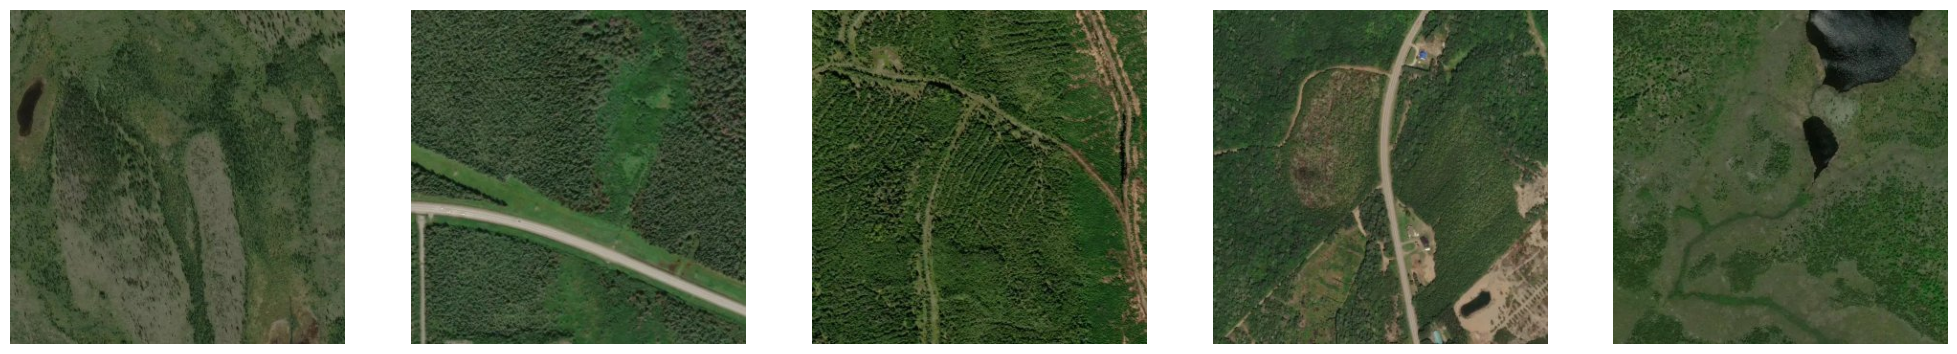

In [32]:
import os
import glob
import matplotlib.pyplot as plt

# Define the concept path and concept name
#concept_name = 'agricultural'
#class_path = "/content/wildfire-prediction-dataset/train"
class_path = "/content/sampled_classes"
class_name = 'wildfire'
class_folder = os.path.join(class_path, class_name)

# Load image filenames (adjusted to load any image type)
image_files = glob.glob(os.path.join(class_folder, '*.*'))

# Load and plot a few images
fig, axs = plt.subplots(1, min(len(image_files), 5), figsize=(25, 5))

for i in range(min(len(image_files), 5)):
    img = plt.imread(image_files[i])
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()

In [37]:
'''
def load_image_tensors(class_name, root_path='/path/to/concepts/', apply_transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.*')  # This should capture all image files

    tensors = []
    for filename in filenames:
        img = get_tensor_from_filename(filename)
        tensors.append(transform(img) if apply_transform else img)

    return tensors
'''

##mixed classes and concepts try again

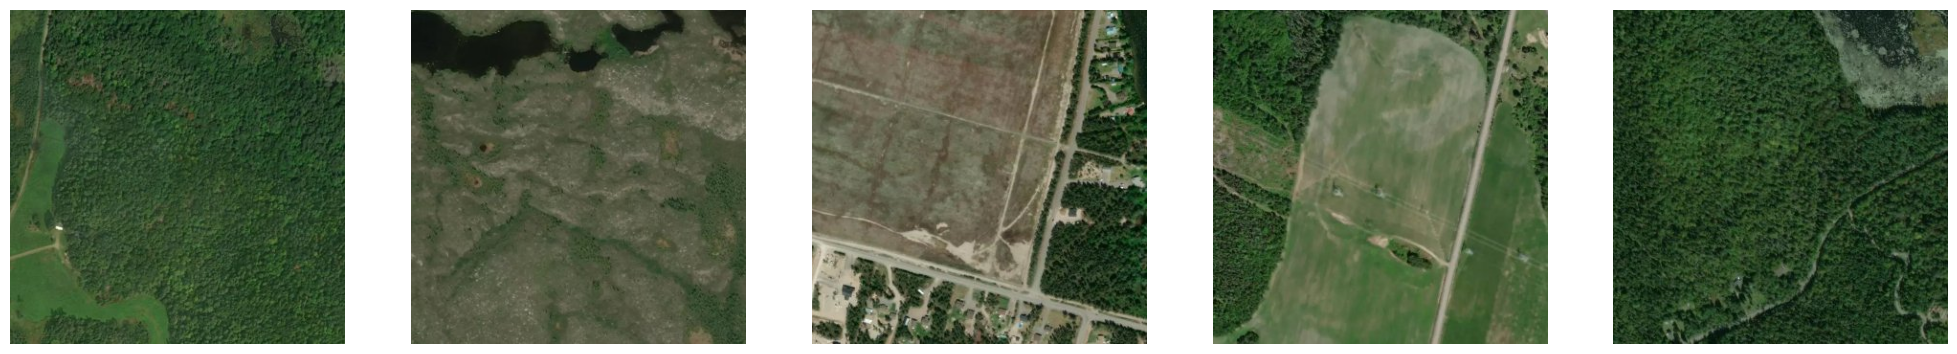

In [33]:
# Load sample images for your class "wildfire"
wildfire_imgs = load_image_tensors('wildfire', root_path="/content/sampled_classes", apply_transform=False)

fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(wildfire_imgs[40])
axs[1].imshow(wildfire_imgs[41])
axs[2].imshow(wildfire_imgs[34])
axs[3].imshow(wildfire_imgs[31])
axs[4].imshow(wildfire_imgs[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()


In [34]:
# Convert wildfire images to tensors
wildfire_tensors = torch.stack([transform(img) for img in wildfire_imgs])


In [35]:
# Wildfire class index
wildfire_ind = 1  # Replace with the correct index


In [38]:
tcav_scores_w_random = mytcav.interpret(inputs=wildfire_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=wildfire_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random


/usr/local/lib/python3.10/dist-packages/captum/concept/_core/cav.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(cavs_path)


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'2-3': defaultdict(None,
                         {'layer4': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 0.1131, -0.1131])}})})

Visualizing some of the images that we will use for making predictions and explaining those predictions by the means of concepts defined above.

Here we perform a transformation and convert the images into tensors, so that we can use them as inputs to NN model.

Auxiliary functions for visualizing of TCAV scores.

Concept: forest
Values: [1.0]
Type of val: <class 'list'>
Length of val: 1

Concept: random500_0
Values: [0.0]
Type of val: <class 'list'>
Length of val: 1



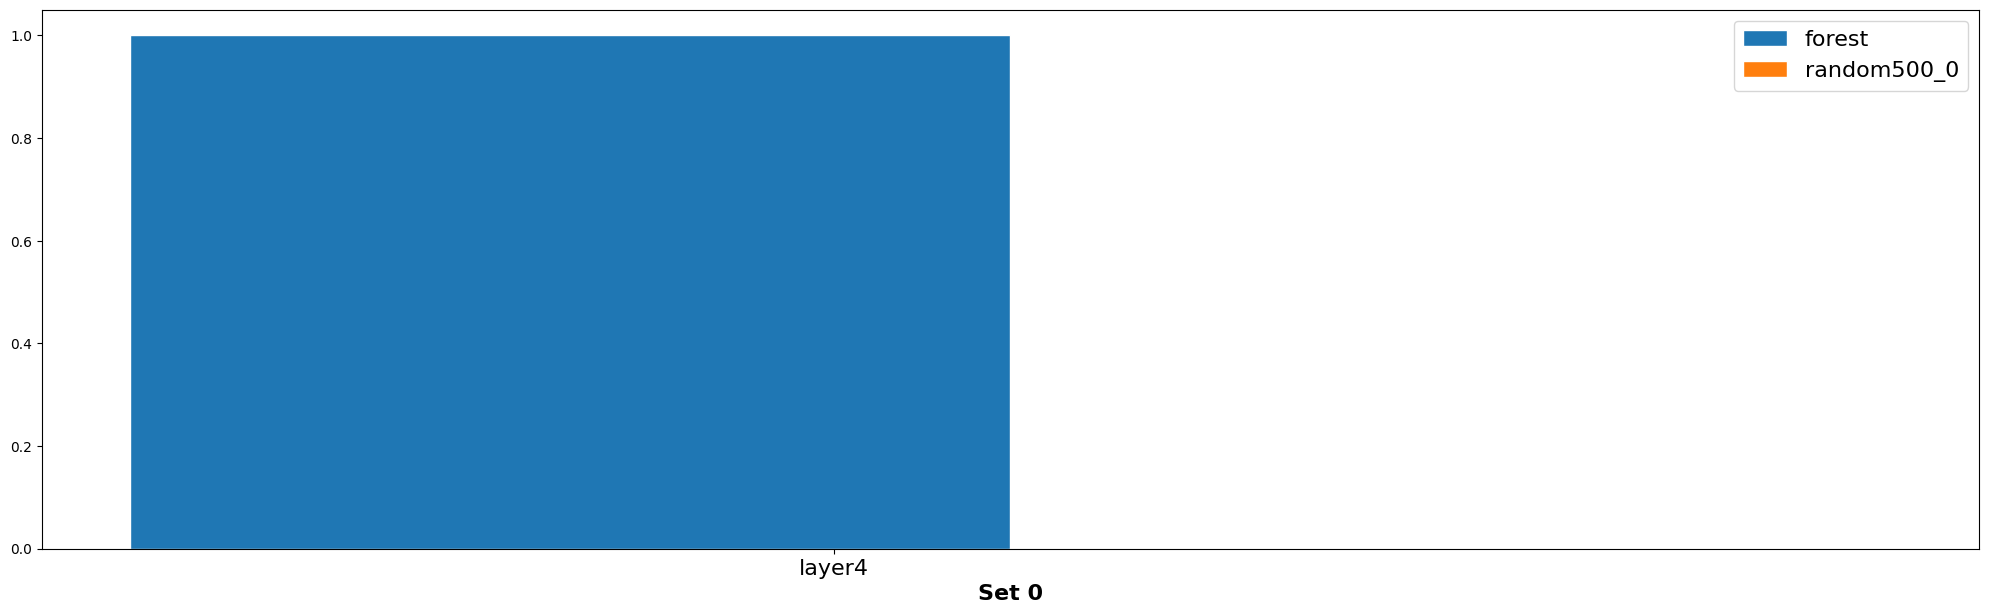

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores, layers):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize=(25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):
        concepts_key = concepts_to_str(concepts)
        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])

        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            # Print the shape and type of `val` for debugging
            print(f"Concept: {concepts[i].name}")
            print(f"Values: {val}")
            print(f"Type of val: {type(val)}")
            print(f"Length of val: {len(val)}\n")

            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

# Example usage with your setup
layers = ['layer4']  # Replace this with the layers you're interested in

plot_tcav_scores(experimental_set_rand, tcav_scores_w_random, layers)


In [45]:
for concept_pair, layers_dict in tcav_scores_w_random.items():
    print(f"Concept Pair: {concept_pair}")
    for layer, scores in layers_dict.items():
        print(f"  Layer: {layer}")
        print(f"    Sign Count: {scores['sign_count']}")
        print(f"    Magnitude: {scores['magnitude']}")


Concept Pair: 2-3
  Layer: layer4
    Sign Count: tensor([0., 1.])
    Magnitude: tensor([-0.0359,  0.0359])


Let's use above defined auxilary functions and visualize tcav scores below.

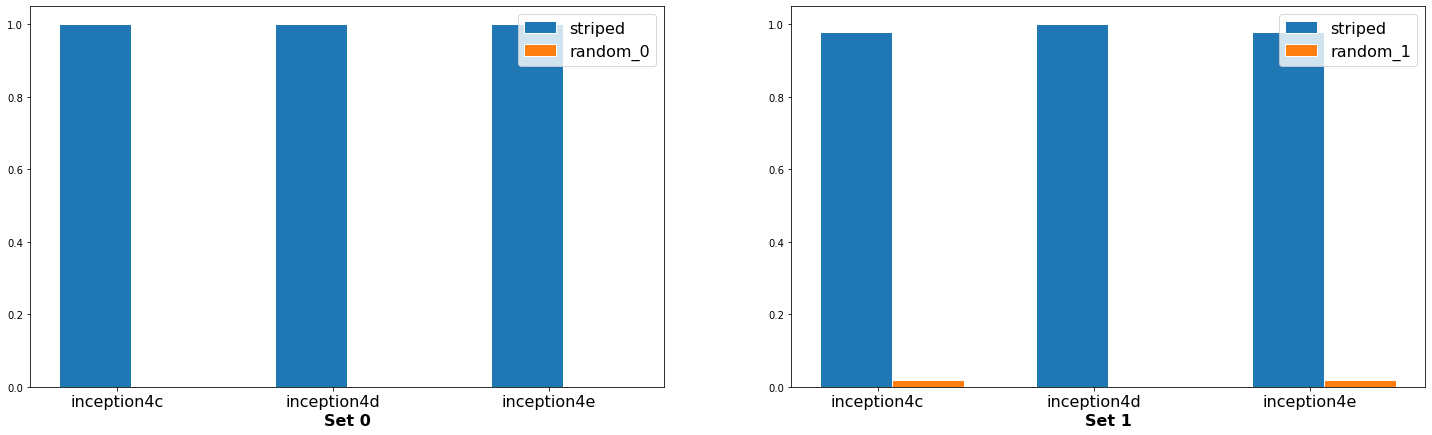

In [ ]:

plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)


From the plot above we observe that the images that are predicted as `zebra` by the model are very sensitive  to `striped` concept as opposed to any random concept. Note that random concepts contain a set of images that are uniformly sampled from imagenet dataset - they do not represent any specific concept.

Now, let's compute TCAV scores for a different experimental set that contains three different specific concepts such as `striped`, `zigzagged` and `dotted`.

In [ ]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]


In [ ]:

tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                         n_steps=5)


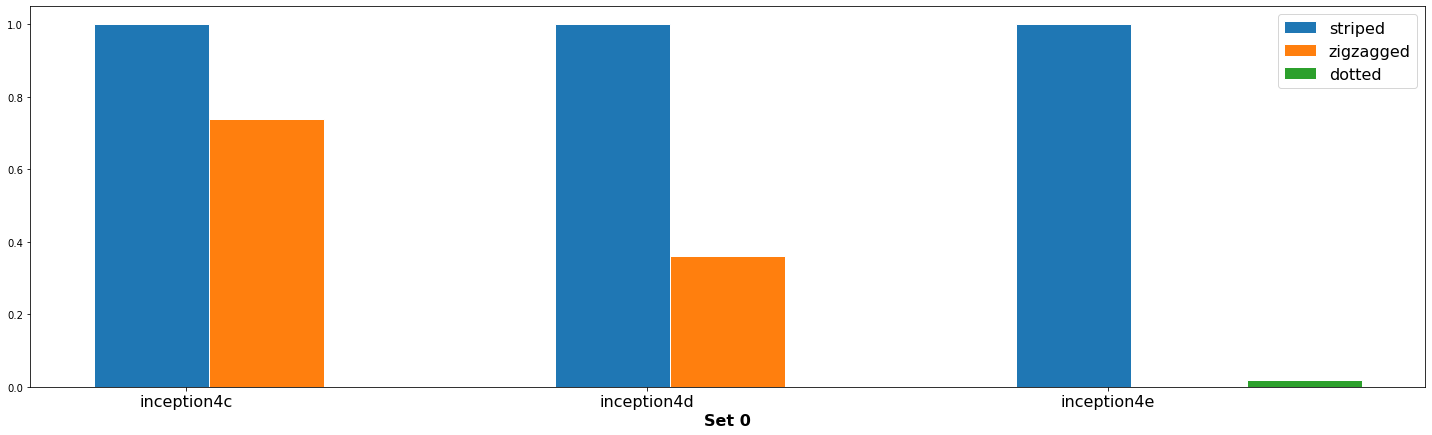

In [ ]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot)

Similar to the previous case in this experiment as well we observe that `striped` concept has very high TCAV scores across all  three layers compared to `zigzagged` and `dotted`. This means that the `striped` concept is an essential concept in predicting `zebra`.  

# Statistical significance testing of concepts

In order to convince ourselves that our concepts truly explain our predictions, we conduct statistical significance tests on TCAV scores by constructing a number of experimental sets. In this case we look into the `striped` concept and a number of random concepts.
If `striped` concept is truly important in predicting `zebra` in the images that contain `zebra`, then we will see consistent high TCAV scores for `striped` concept across all experimental sets as apposed to any other concept.

Each experimental set contains a random concept consisting of a number of random subsamples. In our case this allows us to estimate the robustness of TCAV scores by the means of numerous random concepts.

Let's define those experimental sets in the cell below.


We will look into `striped`, and a number of random concepts drawn uniformly random from imagenet dataset.
```
concept_list = ['stripped', 'ceo', 'random_0', 'random_1', 'random2', ... , 'random_n'], n is the number of concepts
```

Then, we will construct pairs of experimental sets that contain pairs of two concepts. In this case:
```
experimental_sets = [['stripped', 'random_0'], ['stripped', 'random_1'], ... , ['striped', 'random_n'],
                    ['random_0', 'random_1'], ['random_0', 'random_2'], ... , ['random_0', 'random_n']]
```

In [ ]:
n = 2

random_concepts = [assemble_concept('random_' + str(i+2), i+5) for i in range(0, n)]

print(random_concepts)

experimental_sets = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]
experimental_sets.extend([[stripes_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_1_concept])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts])

experimental_sets

[Concept(5, 'random_2'), Concept(6, 'random_3')]


[[Concept(0, 'striped'), Concept(3, 'random_0')],
 [Concept(0, 'striped'), Concept(4, 'random_1')],
 [Concept(0, 'striped'), Concept(5, 'random_2')],
 [Concept(0, 'striped'), Concept(6, 'random_3')],
 [Concept(3, 'random_0'), Concept(4, 'random_1')],
 [Concept(3, 'random_0'), Concept(5, 'random_2')],
 [Concept(3, 'random_0'), Concept(6, 'random_3')]]

Now, let's define a convenience function for assembling the experiments together as lists of Concept objects, creating and running the TCAV:

In [ ]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])

    return score_list

In addition, it is interesting to look into the p-values of statistical significance tests for each concept. We say, that we reject null hypothesis, if the p-value for concept's TCAV scores is smaller than 0.05. This indicates that the concept is important for model prediction.

We label concept populations as overlapping if p-value > 0.05 otherwise disjoint.

In [ ]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):

    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)

    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")

    return P1, P2, format_float(pval), relation


We now run the TCAV and obtain the scores:

In [ ]:
# Run TCAV
scores = mytcav.interpret(zebra_tensors, experimental_sets, zebra_ind, n_steps=5)

We can present the distribution of tcav scores using boxplots and the p-values indicating whether TCAV scores of those concepts are overlapping or disjoint.

In [ ]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

Below box plots visualize the distribution of TCAV scores for two pairs of concepts in three different layers. Each layer is visualized in a separate jupyter cell.
Below diagrams show that `striped` concept has TCAV scores that are consistently high across all layers and experimental sets as apposed to `random` concept. It also shows that `striped` and `random` are disjoint populations.

When we compare the populations of two random concepts we see that the p-value is much higher, meaning that those populations overlap and we cannot reject null hypothesis anymore.

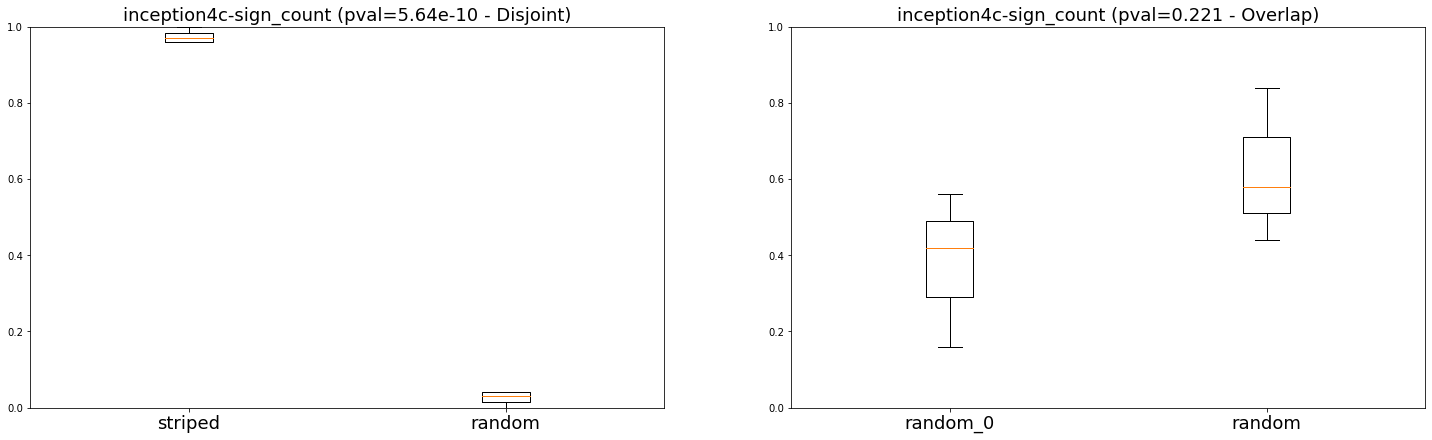

In [ ]:
show_boxplots ("inception4c")

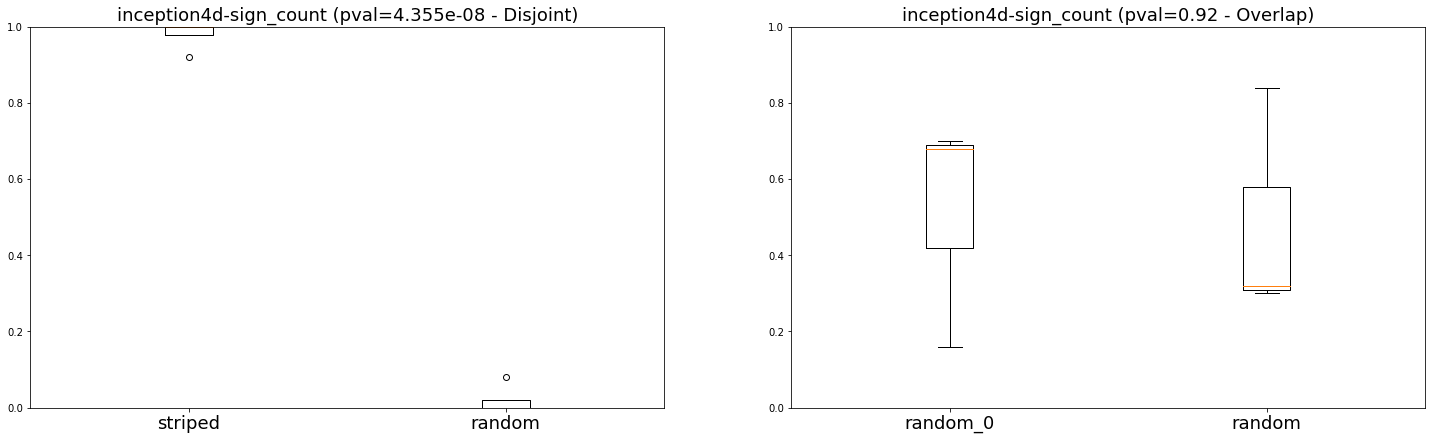

In [ ]:
show_boxplots ("inception4d")

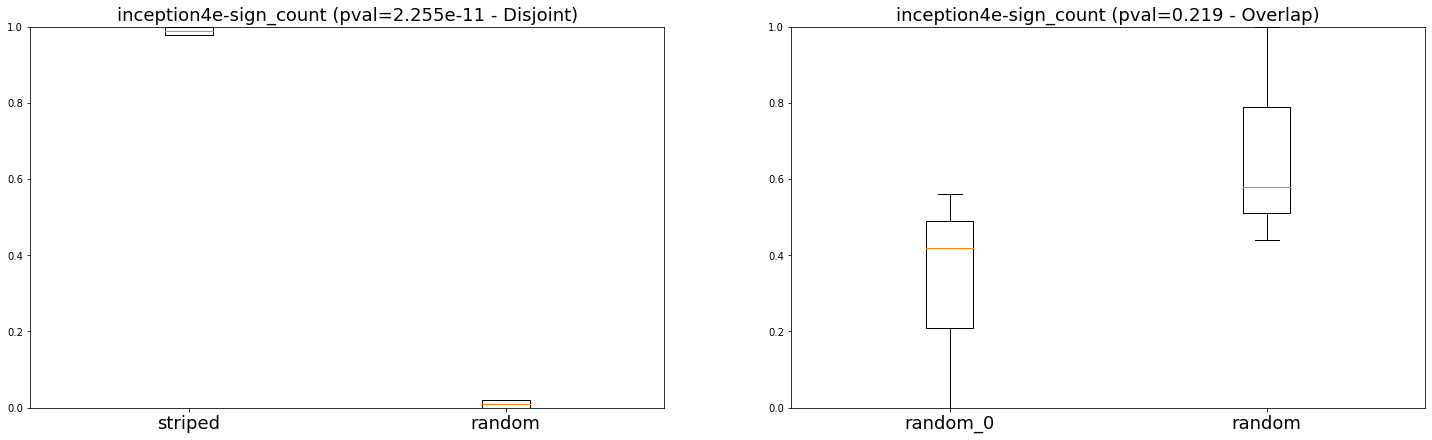

In [ ]:
show_boxplots ("inception4e")